# Continuos Regression with *KQM*

### Concept

We will set `output_dim = 2` so that the model would predict a $2-\dim$ vector: $[cos^2\theta, sin^2\theta]$, and we will actually do the inference over $\theta$. Therefore, the range of the output variable must be within $[0, \pi/2]$.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras import optimizers
from keras import losses
import concurrent.futures
from itertools import product
from keras.layers import Input, Dense, Reshape
import kqm
import itertools
print("Tensorflow version:",tf.__version__)

2024-10-23 21:49:56.934285: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 21:49:57.069978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 21:49:57.070017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 21:49:57.092256: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 21:49:57.140155: I tensorflow/core/platform/cpu_feature_guar

Tensorflow version: 2.15.0


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-10-23 21:50:00.179921: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 21:50:00.258185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 21:50:00.258326: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Check GPU

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Oct 23 21:50:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0               7W /  40W |      9MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Loading Dataset

## CCPP: Combined Cycle Power Plant

https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP)  of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.
We provide the data both in .ods and in .xlsx formats.

Each shuffle is in a single sheet in the .ods file

In [5]:
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

combined_cycle_power_plant = fetch_ucirepo(id=294) 
  
# data (as pandas dataframes) 
X = combined_cycle_power_plant.data.features 
y = combined_cycle_power_plant.data.targets 

## 70% - 30% Hold Out and MinMax Scaling for `y` 

In [6]:
from sklearn.model_selection import train_test_split

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

scaler_x = StandardScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)

scaler = MinMaxScaler(feature_range=(0.2, np.pi/2-0.2))
scaler.fit(y_train)
y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test))
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

print(f"Training features size: {X_train.shape}")
print(f"Training labels size: {y_train.shape}")

Training set size: (6697, 4)
Test set size: (2871, 4)
Training features size: (6697, 4)
Training labels size: (6697,)


## Defining KQM-Model

In [7]:
n_comp=32

In [8]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(4,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

## Training and Test

2024-10-23 21:59:15.949430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 21:59:15.949620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 21:59:15.949699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

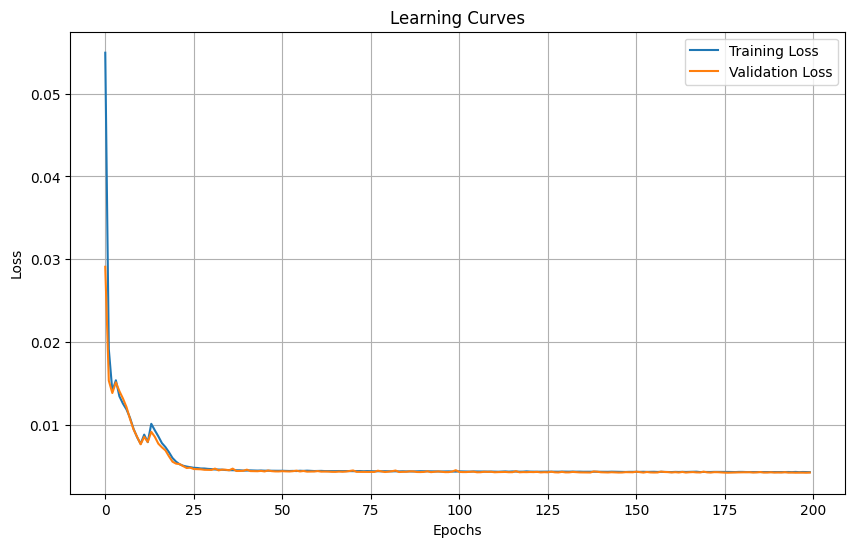

MAE = 3.303500245246103
MSE = 18.16717770917949
R^2 = 0.9380297454326431


In [9]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=50,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = 4
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

# Initializing weights `c_y`

ok


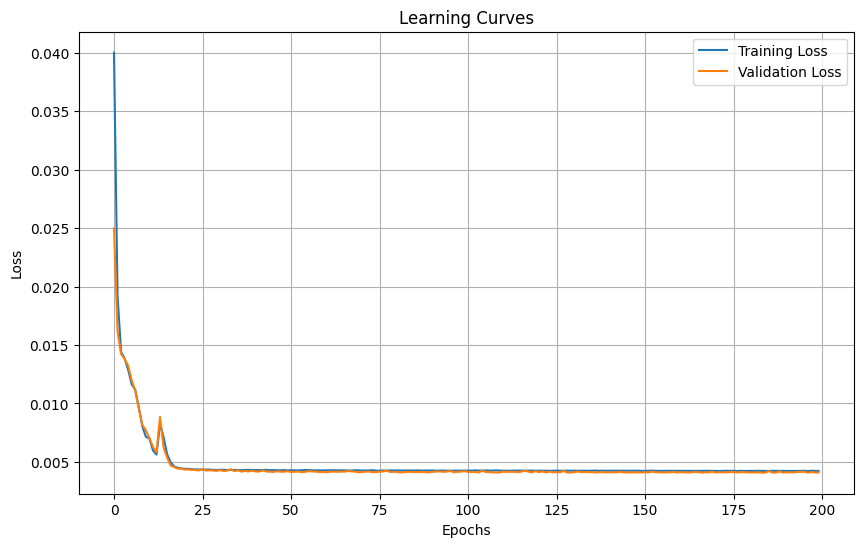

MAE = 3.2673518161647457
MSE = 17.720458218351514
R^2 = 0.9395535550749532


In [10]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=100,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = 4
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
selected_labels = y_train[indices]
cos_values = np.cos(selected_labels)
sin_values = np.sin(selected_labels)
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
kqm_model.kqm_unit_encoded.c_y.assign(np.column_stack((cos_values, sin_values)))
print('ok')

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

In [11]:
y_pred

array([455.16696, 438.70236, 434.44925, ..., 472.3231 , 476.56485,
       440.64685], dtype=float32)

In [12]:
y_test

array([455.27, 436.31, 440.68, ..., 477.18, 481.95, 441.57])

# Hyper-parameter exploration

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
```

In [13]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']

# Some fixed hyper-params
encoding_dim = 4
num_hidden_layer = 1
n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [14]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(4,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [15]:
best_MSE = 1000

for lr, kernel in itertools.product(learning_rates, kernels):
    print(f"Running experiment with learning_rate={lr} and kernel={kernel}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05 and kernel=rbf
MAE = 5.892457650402869
MSE = 57.46664775899602
R^2 = 0.803974902003727
New best model
Running experiment with learning_rate=1e-05 and kernel=cos
MAE = 14.348257496673362
MSE = 275.7755550177407
R^2 = 0.059299049005922644
Running experiment with learning_rate=5e-05 and kernel=rbf
MAE = 3.372563278426779
MSE = 19.500972553933064
R^2 = 0.9334800235444577
New best model
Running experiment with learning_rate=5e-05 and kernel=cos
MAE = 14.003987396782344
MSE = 260.26547737993076
R^2 = 0.11220564104574726
Running experiment with learning_rate=0.0001 and kernel=rbf
MAE = 3.3026905865803777
MSE = 18.0699465736186
R^2 = 0.9383614116011055
New best model
Running experiment with learning_rate=0.0001 and kernel=cos
MAE = 13.6899423573865
MSE = 251.1082669996688
R^2 = 0.14344189950459096
Running experiment with learning_rate=0.0005 and kernel=rbf
MAE = 3.2690892194098855
MSE = 17.745550116181377
R^2 = 0.9394679638333753
New best model
Runni

```
Running experiment with learning_rate=0.001 and kernel=rbf
MAE = 3.284298762816745
MSE = 17.701638709900546
R^2 = 0.9396177505019043
New best model
```

## Adding an Encoder

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [6, 8, 16]
num_hidden_layer = [1,2]
```

In [16]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [4, 8, 16]
num_hidden_layers = [1,2]

# Some fixed hyper-params

n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [17]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(4,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [18]:
best_MSE = 1000

for lr, kernel, encoding_dim, num_hidden_layer in itertools.product(learning_rates, kernels, encoding_dim, num_hidden_layers):
    print(f"Running experiment with learning_rate={lr}, kernel={kernel}, encoding_dim={encoding_dim} and num_h_l={num_hidden_layer}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=True)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel, encoding_dim, num_hidden_layer)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=4 and num_h_l=1
MAE = 5.0977043837996066
MSE = 42.27714062121203
R^2 = 0.8557879925756071
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=4 and num_h_l=2
MAE = 6.255914756910429
MSE = 58.58695237149807
R^2 = 0.8001534189345842
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=8 and num_h_l=1
MAE = 4.80661812511565
MSE = 36.98298969629447
R^2 = 0.8738469275289091
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=8 and num_h_l=2
MAE = 5.391827529487357
MSE = 47.87116125855089
R^2 = 0.8367061688327934
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 4.59381526276028
MSE = 33.97295573959961
R^2 = 0.8841144866147939
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 4.16031957676169
MSE = 27.865829980027414
R^2 = 0.9049465687386079


```
Running experiment with learning_rate=0.005, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 3.0999949292561935
MSE = 16.455257189576752
R^2 = 0.9438692958623864
New best model
```

So, an encoder does improves the performance in this case.

In [19]:
y_test.max(), y_test.mean(), y_test.min()

(495.35, 454.2635597352839, 425.11)